### Import the needed libraries

In [1]:
import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Mirza Anaqi\AppData\Local\Temp\ipykernel_27332\3209713608.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Clean the data
As duplicates can be found in the dataset; with filenames ending with (1), (2), (3), etc., we clean the data by removing said duplicates.

In [30]:
import os
import re

data_dir = '../../dataset_26'

# Regular expression pattern to match filenames ending with (1), (2), (3), etc.
pattern = re.compile(r'\(\d+\)\.\w+$')

# Iterate over each folder in the dataset
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            
            # Check if the filename matches the pattern
            if pattern.search(image):
                # Remove the duplicate image
                os.remove(image_path)

### Load the images

Found 454 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


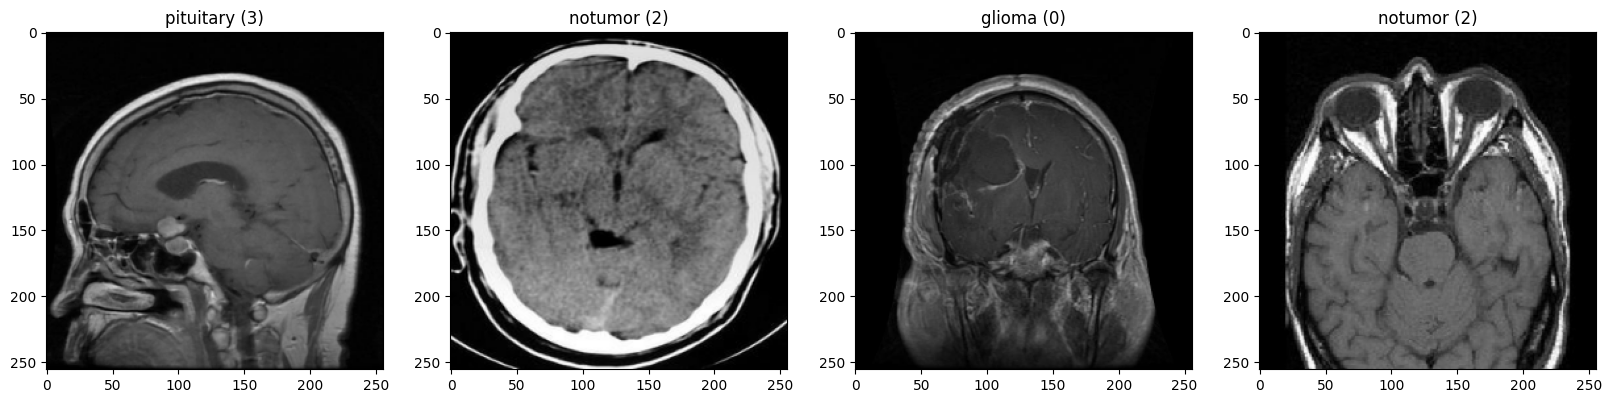

In [32]:
# create data directory and consider only image file format types
# each folder is a category
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

data = tf.keras.utils.image_dataset_from_directory(data_dir)

class_names = data.class_names
print(class_names)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

# establish the data pipeline to load the data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    class_label = class_names[batch[1][idx]]
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f'{class_label} ({batch[1][idx]})')

### Split the images

Scale the data. Map function enanbles transformation inside the pipeline. Split the Data to: 70% Train, 20% Validation and 10% Test. The number of batches is dependent on total sample size.

In [33]:
# Scale the data
# map function enenbles transformation inside the pipeline
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7) # training set will be 70% of data
val_size = int(len(data)*.2) # validation set size will be 20% of data
test_size = int(len(data)*.1) # test size will be 10%

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Build the model

Build the deep Learning Model. Our sequential API is suitable for our basic single input model. Functional API would be more complicated, for multi input, residual networks. Model subclassing would be suitable for layer blocks. MaxPooling2D is condensing image down. The model uses the efficient Adam optimization algorithm for gradient descent, to adjust the weights of the network and to minimize the loss function. Binary Crossentropy computes the cross-entropy loss between true labels and predicted labels.

In [34]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


model = Sequential() # create a model with sequential class

# Layers are added sequentialy
# 1st layer: convolution has 16 filters (3 x 3 pixels inside).
# The power is coming from activation function. Relu is replacing null values.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())

# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten the data again down
model.add(Flatten())

# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values

# Final layer with 4 neurons and softmax activation for 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()
# if the layer is not trainable, there is 0 in Param column
# total params stands for the total size of our model

C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Fitting the model. Loss is decresing with each epoch and accuracy is raising. The last epoch has 95% accuracy. Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the sigmoid classification technique in the second dense layer. 11 is a sufficient epoch count, more epochs does not lead to better model performance.

In [35]:
# Create a folder to save your callbacks
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

hist.history

Epoch 1/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 510ms/step - accuracy: 0.3153 - loss: 1.4173 - val_accuracy: 0.5625 - val_loss: 1.0745
Epoch 2/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - accuracy: 0.6246 - loss: 1.0020 - val_accuracy: 0.6667 - val_loss: 0.8171
Epoch 3/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step - accuracy: 0.7236 - loss: 0.7323 - val_accuracy: 0.7396 - val_loss: 0.6272
Epoch 4/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - accuracy: 0.7266 - loss: 0.5885 - val_accuracy: 0.8438 - val_loss: 0.4250
Epoch 5/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.8592 - loss: 0.3818 - val_accuracy: 0.9271 - val_loss: 0.2566
Epoch 6/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.8784 - loss: 0.3257 - val_accuracy: 0.8854 - val_loss: 0.2951
Epoch 7/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.9047 - loss: 0.2594 - val_accuracy: 0.9375 - val_loss: 0.1829
Epoch 8/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - accuracy: 0.9591 - loss: 0.1510 - val_accuracy: 0.

{'accuracy': [0.39375001192092896,
  0.6156250238418579,
  0.7406250238418579,
  0.762499988079071,
  0.840624988079071,
  0.893750011920929,
  0.9125000238418579,
  0.953125,
  0.9624999761581421,
  0.9906250238418579,
  0.9906250238418579],
 'loss': [1.305804967880249,
  0.9672597646713257,
  0.6838061809539795,
  0.5562618374824524,
  0.3971480429172516,
  0.29982808232307434,
  0.2573140263557434,
  0.16153249144554138,
  0.1228111982345581,
  0.05317600443959236,
  0.04235798120498657],
 'val_accuracy': [0.5625,
  0.6666666865348816,
  0.7395833134651184,
  0.84375,
  0.9270833134651184,
  0.8854166865348816,
  0.9375,
  0.96875,
  0.9791666865348816,
  0.9895833134651184,
  0.9895833134651184],
 'val_loss': [1.074472188949585,
  0.81709885597229,
  0.6271824836730957,
  0.42503106594085693,
  0.2566355764865875,
  0.2950921952724457,
  0.18289659917354584,
  0.16480344533920288,
  0.06019803509116173,
  0.05605138838291168,
  0.0392724834382534]}

### Performance Evaluation

#### 1. Evaluate Loss and Accuracy Curves
If loss and validation go down: OK. If the loss goes down, but validation goes up: model is overfitting and you must change the data. If the loss or valiadation is constant, model is not able to learn and you must change more input parameters. The ideal would be to result in accuracy 100%. Consider more files to increase the accuracy, not only 155 pictures we used.

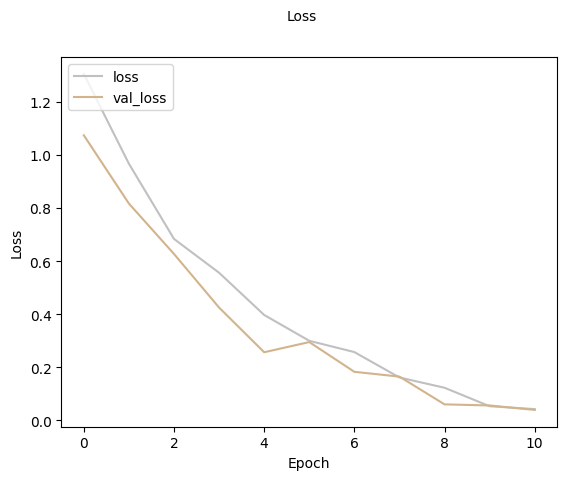

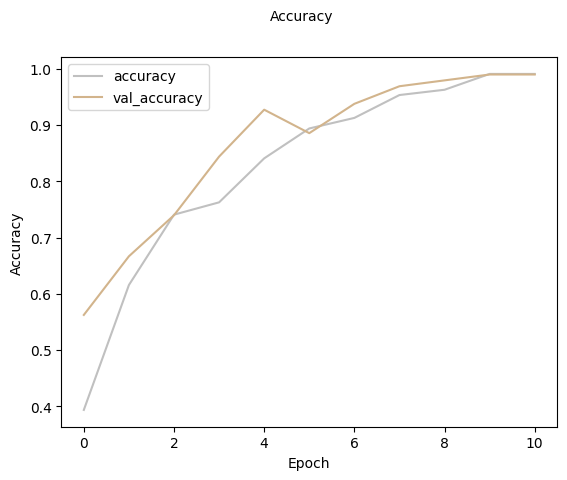

In [36]:
# Revise the model Performance
# if loss and validation go down: OK
# if loss goes down, but validation goes up: model is overfitting. You must change the data.
# if loss or valiadation is constant, model is not able to learn and you must change more parameters.
fig = plt.figure()
plt.plot(hist.history['loss'], color='silver', label='loss')
plt.plot(hist.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

# ideal would be to result in accuracy 100%. Consider more files to increase the accuracy.
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='silver', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

#### 2. Evaluate on the Test Dataset

In [37]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 1.0000 - loss: 0.0394
Test Loss: 0.03944559767842293
Test Accuracy: 1.0


#### 3. Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


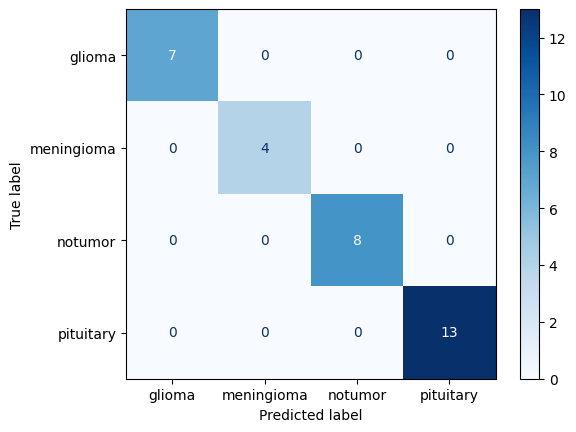

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels and predictions for the test set
y_true = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 4. Classification Report

In [39]:
from sklearn.metrics import classification_report

# Generate the classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00         7
  meningioma       1.00      1.00      1.00         4
     notumor       1.00      1.00      1.00         8
   pituitary       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



#### 5. ROC and AUC

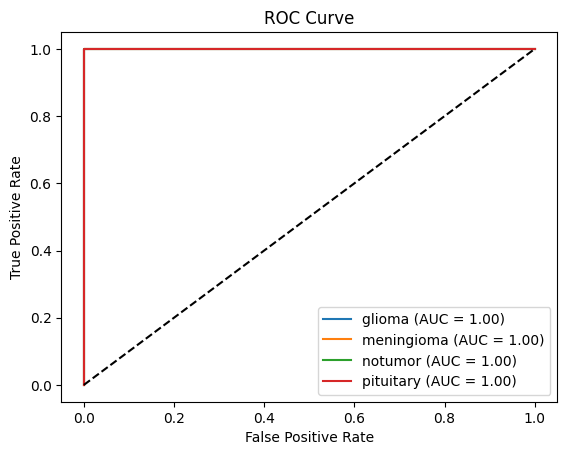

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for ROC and AUC calculation
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3])

# Plot ROC curves for each class
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

### Classify the new image

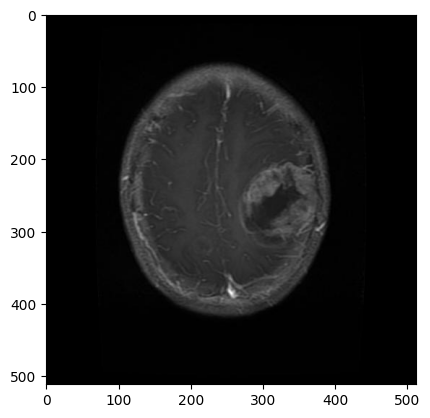

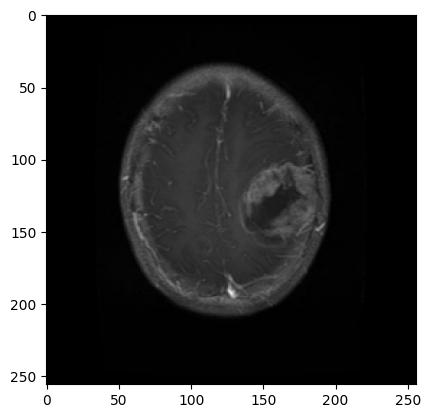

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class is glioma


In [41]:
# Load the image
img = cv2.imread('test1.jpg')  # bgr colors
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change bgr colors to rgb
plt.show()

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the image
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Expand the dimensions of the resized image
input_image = np.expand_dims(resize / 255.0, 0)  # Normalize the image

# Make the prediction
test_prediction = model.predict(input_image)

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get the predicted class index
predicted_class_index = np.argmax(test_prediction, axis=-1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the prediction
print(f'Predicted class is {predicted_class_name}')

### Conclusion
From the evaluations done on the model, there may be some issues that can be found. The model might be overfitting if the dataset is small or if the data is not diverse enough. The dataset may be too small (454 files), so achieving 100% accuracy might not be surprising. May need to ensure the dataset is sufficiently large and diverse to generalize well.